In [1]:
import os
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

In [2]:
# -----------------------
# Tools
# -----------------------

import base64
import requests
def analyze_image(image_path):
    api_key = os.environ.get("OPENAI_API_KEY")
    
    headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {api_key}"
    }

    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode('utf-8')
        
    payload = {
      "model": "gpt-4o-mini",
      "max_tokens": 300,
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": "What’s in this image?"
            },
            {
              "type": "image_url",
              "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
            }
          ]
        }
      ],
    }
    
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    # {'id': 'chatcmpl-9RRYu5W77ZoNKUUsdp84XFk2Pbxvg', 'object': 'chat.completion', 'created': 1716327832, 'model': 'gpt-4o', 
    #  'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The image displays multiple DVD or poster covers for ...'}, 
    #               'logprobs': None, 'finish_reason': 'stop'}], 
    #  'usage': {'prompt_tokens': 1118, 'completion_tokens': 142, 'total_tokens': 1260}, 'system_fingerprint': 'fp_927397958d'}
    print(response.json())
    result = response.json()['choices'][0]['message']['content']
    return result

#analyze_image(image_path="../input_images/image.demo.0.png")


from tavily import TavilyClient
def search_engine( query ):
    result = ""
    print("Search Engine Query:", query)

    tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])
    response = tavily.search(query=query, max_results=2)
    for content in response["results"]:
        result += content["content"]
    return result

#search_engine("What is James Bond's nationality ?")


# -----------------------
# Tool Calling Support
# -----------------------

import inspect
class Function:
    def __init__(self, func):
        self.func = func
        self.name = func.__name__
        self.arg_def = {}
        for name, param in inspect.signature(self.func).parameters.items():
            # {'ticker': {'type': <class 'str'>, 'value': None, 'default': <class 'inspect._empty'>}}
            self.arg_def[ name ]={"type":param.annotation, "value":None, "default":param.default}            
        # i.e. <class 'float'>
        self.return_type = inspect.signature(self.func).return_annotation
        
class ToolCall:
    def __init__(self, func):
        self.function = Function(func)
        self.arguments = {}

    def __call__(self, parameter):
        for key, arg_def in self.function.arg_def.items():
            self.function.arg_def[ key ]["value"]=parameter
            self.arguments[ key ]=parameter
        result = self.function.func(parameter)
        print("calling:", self.function.name, "args:", self.function.arg_def, "result:", result)
        return result

#tool = ToolCall(analyze_image)
#print(tool("../input_images/image.demo.0.png"))

#tool = ToolCall(search_engine)
#print(tool("What nationality is James Bond ?"))


from openai import OpenAI
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

def check_tools_invocation(dialog, tools):    
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

    _dialog = dialog
    _tools = "Tools:\n"
    for tool in tools:
        _tools += "- "+tool["description"]+"\n"

    _prompt = """
    ### Instruction: If there is an explicit request for information in the input dialog, see if an input tool can answer it, then identify the tool and parameter needed, otherwise return '' for tool and parameter.

    ### Input:
    Input Dialog:
    %s
    
    Input Tools: 
    %s

    Format Instructions:
    %s
    
    ### Response:
    """

    tool_name_schema = ResponseSchema(name="tool", description="output the name of the tool")
    parameter_schema = ResponseSchema(name="parameter", description="output the value of parameter to be passed into the tool")

    response_schemas = [tool_name_schema, parameter_schema]
    output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
    
    _format_instructions = output_parser.get_format_instructions()
    _prompt = _prompt % (_dialog, _tools, _format_instructions)
    
    messages=[{"role": "system", "content": ""}, {"role": "user", "content": _prompt}]
    completion = client.chat.completions.create(model="gpt-4o-mini", messages=messages) 
    result_dict = output_parser.parse(completion.choices[0].message.content)
    # i.e. result_dict={'tool': 'get_stock_price', 'parameter': 'NVIDIA'}
    print("Tool Matching Result:", result_dict)

    result = None
    for tool in tools:
        # i.e. {"tool": ToolCall(), "description":tool_description}
        if result_dict["tool"]==tool["tool"].function.name:    # ToolCall.function
            result = tool["tool"]( result_dict["parameter"] )  # ToolCall.__call__
        
    return result


_dialog = """
i'm fine, how are you doing
"""
# UNIT TESTS:
# how are you doing
# can you check Tesla Stock
# can you describe this image '../input_images/image.demo.0.png'
# do you know what happened recently with Charlotte Flair ?


# Test tool invocation support
tools = []
tools.append( {"tool": ToolCall(analyze_image), "description":"name: analyze_image, parameter: image that needs to be described, returns: description of image"} )
tools.append( {"tool": ToolCall(search_engine), "description":"name: search_engine, parameter: request, returns: answer to request"} )

check_tools_invocation(_dialog, tools)


Tool Matching Result: {'tool': '', 'parameter': ''}


In [3]:
import re
import time
from openai import OpenAI

system_prompt="""You are a personal companion having a dialog with a User. \
System prompts will be provided to help drive the conversation including \
description of images or answers to questions. 
Try to elicit some topic the user is interested in to discuss.
"""

def call_open_ai(messages):
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    # https://platform.openai.com/docs/models/overview
    # https://platform.openai.com/account/billing/preferences
    # https://platform.openai.com/account/usage
    
    completion = client.chat.completions.create(model="gpt-4o-mini", messages=messages)
    return completion.choices[0].message.content

class Conversation:
    def __init__(self, system_prompt=""):
        self.messages = []
        self.tools = []
        
        if system_prompt:
            self.messages.append({"role": "system", "content": system_prompt})

        self.tools.append( {"tool": ToolCall(analyze_image),   "description":"name: analyze_image, parameter: image that needs to be described, returns: description of image"} )
        self.tools.append( {"tool": ToolCall(search_engine),   "description":"name: search_engine, parameter: request, returns: answer to request"} )

    def system(self, system_prompt):
        self.messages.append({"role": "system", "content": system_prompt})

    def assistant(self, assistant_prompt):
        self.messages.append({"role":"assistant", "content":assistant_prompt})

    def user(self, user_prompt):
        self.messages.append({"role":"user", "content":user_prompt})

    def chat(self):
        if self.tools and self.messages:
            _dialog = []
            #for message in self.messages:
            #    _dialog.append(message['content'])
            _dialog.append(self.messages[-1]['content'])
            _dialog = "\n".join(_dialog)
            invoke_response = check_tools_invocation(_dialog, self.tools)
            if invoke_response:
                self.system( invoke_response + " Please explain to user in 1 to 2 sentences." )
                #self.messages.append({"role": "system", "content": invoke_response + " Please explain to user in 1 to 2 sentences."})
            
        response = call_open_ai(messages=self.messages)
        self.messages.append({"role":"assistant", "content":response})
        return response
        
    def generate(self, user_prompt):
        self.messages.append({"role": "user", "content":user_prompt})
        response = call_open_ai(messages=self.messages)
        self.messages.append({"role":"assistant", "content":response})
        
        return response


In [ ]:
import os
import requests
import numpy as np

import random
import time
from datetime import datetime
import json

from flask import Flask, request, jsonify, render_template, send_file


glob = {}

glob["prompt"]={}
glob["message_counter"] = {}
glob["current_app_state"] = {}
glob["conversation_object"] = {}


from moviepy.editor import *
import scipy.ndimage
import openai

def generate_voice_and_video(user, text, stay_silent_and_blink=False):
    print("Generating voice with OpenAI TTS")

    # === TEXT TO SPEECH via OpenAI ===
    openai.api_key = os.getenv("OPENAI_API_KEY")

    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # Male voice
        input=text
    )

    audio_path = "static/audio.mp3"
    with open(audio_path, "wb") as f:
        f.write(response.content)

    if stay_silent_and_blink:
        audio_path = "static/silence.mp3"

    # === Load audio ===
    audio_clip = AudioFileClip(audio_path)
    samples = audio_clip.to_soundarray()

    # === Define image frames ===
    image_files = ["frame_rest.jpg", "frame_soft.jpg", "frame_loud.jpg", "frame_blink.jpg"]
    images = []

    freq = 15  # frames per second
    total_frames = int(max(audio_clip.duration, 1) * freq)
    volumes = []

    # === Step 1: Extract RMS volume for each frame ===
    for i in range(total_frames):
        start = int(i * audio_clip.fps / freq)
        end = int((i + 1) * audio_clip.fps / freq)
        segment = samples[start:end, 0]
        rms = np.sqrt(np.mean(segment ** 2)) if len(segment) > 0 else 0
        volumes.append(rms)

    # === Step 2: Normalize and smooth ===
    volumes = np.array(volumes)
    if volumes.max() > 0:
        volumes = volumes / volumes.max()

    smoothed_volumes = scipy.ndimage.uniform_filter1d(volumes, size=3)

    # === Step 3: Map volume to mouth frames ===
    for idx, v in enumerate(smoothed_volumes):
        if stay_silent_and_blink:
            images.append(image_files[0])  # rest
            #if idx % 24 == 0:
            #    images.append(image_files[3])  # blink
            #else:
            #    images.append(image_files[0])  # rest
        else:
            if v > 0.6:
                images.append(image_files[2])  # loud
            elif v > 0.3:
                images.append(image_files[1])  # soft
            elif idx % 12 == 0:
                images.append(image_files[1])  # occasional loud
            else:
                images.append(image_files[0])  # rest

    # === Build the video ===
    image_sequence = ImageSequenceClip(images, fps=freq).resize(height=320, width=240)
    final_clip = image_sequence.with_audio(audio_clip)

    output_path = "static/video_" + user + str(glob["message_counter"][user]) + ".mp4"
    final_clip.write_videofile(output_path, codec='libx264', bitrate="80k")



app = Flask(__name__)

@app.route("/")
def index():
    user = "demo"
    
    glob["message_counter"][ user ]=0
    glob["current_app_state"][ user ]="initializing"
    glob["conversation_object"][ user ]=Conversation(system_prompt=system_prompt)
                
    glob["prompt"][ user ]=""

    first_message = ""
    random.seed(time.time())
    first_message = random.choice( ["hey, hows it going", "hi, how are you", "hi, hows it going", "hey, how are you doing", "hey, hows it going", "hi, how are you", "hi, hows it going", "hello, how are you doing"] )

    print("The Initial Prompt is: ", system_prompt)    
    print("First Greeting: ", first_message)

    speech2text_app_id = os.environ.get("SYMBL_AI_APP_ID")
    speech2text_app_secret = os.environ.get("SYMBL_AI_APP_SECRET")

    return render_template("index.html", user=user, message=first_message, speech2text_app_id=speech2text_app_id, speech2text_app_secret=speech2text_app_secret)
    
@app.route("/initialize", methods=["POST"])
def initialize():
    user = request.get_json()["user"]
    text = request.get_json()["text"]
    image_prompt = response = ""
    
    print("Received: ", text, " from: ", user)
        
    if glob["current_app_state"][ user ]=="initializing":
        glob["current_app_state"][ user ]="running"

        # no call to chatGPT here but we will generate voice and wait for next chat
        glob["prompt"][ user ] += "Assistant: " + text + "\n"
        glob["conversation_object"][ user ].assistant( text )

        # generate voice after we get the assistant's next line
        generate_voice_and_video( user, text )

    elif glob["current_app_state"][ user ]=="running":
        assert(False)

    video_file = "video_"+user+str(glob["message_counter"][user])+".mp4"
    glob["message_counter"][user]+=1

    result = jsonify({"video_file": video_file, "image_prompt": image_prompt, "response":response})
    return result
    
@app.route("/chat_think", methods=["POST"])
def chat_think():
    
    user = request.get_json()["user"]
    text = request.get_json()["text"]
    image_data = request.get_json()["image"]

    image_prompt = response = ""
    
    print("Received: ", text, " from: ", user)

    # Process any image that is sent with the chat
    if image_data != "":
        image_data = image_data.replace('data:image/png;base64,', '')
        
        # Save the image locally
        current_dir = './'
        image_file = 'static/image.'+user+'.'+datetime.now().strftime("%Y-%m-%d_%H:%M:%S")+'.png'
        with open(current_dir + image_file, 'wb') as f:
            f.write(base64.b64decode(image_data))

        text = text+". Please describe this image '"+current_dir+image_file+"'"
        response = "pause and think"
        
    # Add the user response to the conversation
    glob["prompt"][ user ] += "User: " + text + "\n"
    glob["conversation_object"][ user ].user( text )

    # (A) Send Dialog to Observers ...
    
    dialog = glob["prompt"][ user ] 
    message_content = {}
    message_content["user"]=user
    message_content["dialog"]=dialog
    message_content["message_counter"]=glob["message_counter"][user]


    # Process fastpath queries
    stay_silent_and_blink = False
    if response=="pause and think":
        response = random.choice(["ok, let me think", "ok, let me see", "let me think, give me a sec", "give me a sec, let me think"])
        
    else:
        stay_silent_and_blink = True
        response = "thinking"
    
    start_time = time.time()
    
    # generate voice after we get the assistant's next line
    generate_voice_and_video( user, response, stay_silent_and_blink=stay_silent_and_blink )

    end_time = time.time()
    print("* generate_voice_and_video Elapsed time:", end_time - start_time)    

    video_file = "video_"+user+str(glob["message_counter"][user])+".mp4"
    glob["message_counter"][user]+=1

    result = jsonify({"video_file": video_file, "image_prompt": image_prompt, "response":response})
    return result


@app.route("/think_reply", methods=["POST"])
def think_reply():
    
    user = request.get_json()["user"]
    text = request.get_json()["text"]
    
    image_prompt = response = ""

    glob["prompt"][ user ] += "Assistant: " 
        
        
    # We call chatGPT for the next response. 
    start_time = time.time()

    # Continue the conversation ...
    response = glob["conversation_object"][ user ].chat()
    
    glob["prompt"][ user ] += response + "\n"
    
    end_time = time.time()
    print("* call_open_ai Elapsed time:", end_time - start_time)
    

    # Generate voice after we get the assistant's next line
    start_time = time.time()
    
    generate_voice_and_video( user, response )

    end_time = time.time()
    print("* generate_voice_and_video Elapsed time:", end_time - start_time)


    video_file = "video_"+user+str(glob["message_counter"][user])+".mp4"
    glob["message_counter"][user]+=1

    result = jsonify({"video_file": video_file, "image_prompt": image_prompt, "response":response})

    return result



from http.server import BaseHTTPRequestHandler
class RequestHandler(BaseHTTPRequestHandler):
  def setup(self):
    BaseHTTPRequestHandler.setup(self)
    self.request.settimeout(120)

if __name__ == "__main__":
    app.run(host='0.0.0.0', port=8888, threaded=True)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8888
 * Running on http://10.0.0.187:8888
Press CTRL+C to quit
127.0.0.1 - - [28/Jul/2025 11:30:18] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Jul/2025 11:30:19] "GET /static/inprogress.gif HTTP/1.1" 200 -


The Initial Prompt is:  You are a personal companion having a dialog with a User. System prompts will be provided to help drive the conversation including description of images or answers to questions. 
Try to elicit some topic the user is interested in to discuss.

First Greeting:  hi, hows it going


127.0.0.1 - - [28/Jul/2025 11:30:19] "GET /favicon.ico HTTP/1.1" 404 -


Received:  hi, hows it going  from:  demo
Generating voice with OpenAI TTS
MoviePy - Building video static/video_demo0.mp4.
MoviePy - Writing audio in video_demo0TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video static/video_demo0.mp4



127.0.0.1 - - [28/Jul/2025 11:30:22] "POST /initialize HTTP/1.1" 200 -                                                                                                                               
127.0.0.1 - - [28/Jul/2025 11:30:22] "GET /static//video_demo0.mp4 HTTP/1.1" 308 -
127.0.0.1 - - [28/Jul/2025 11:30:22] "GET /static/video_demo0.mp4 HTTP/1.1" 206 -


MoviePy - Done !
MoviePy - video ready static/video_demo0.mp4


127.0.0.1 - - [28/Jul/2025 11:30:23] "GET /favicon.ico HTTP/1.1" 404 -


Received:  good, you ?  from:  demo
Generating voice with OpenAI TTS
MoviePy - Building video static/video_demo1.mp4.
MoviePy - Writing audio in video_demo1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video static/video_demo1.mp4



127.0.0.1 - - [28/Jul/2025 11:30:32] "POST /chat_think HTTP/1.1" 200 -                                                                                                                               
127.0.0.1 - - [28/Jul/2025 11:30:32] "GET /static//video_demo1.mp4 HTTP/1.1" 308 -
127.0.0.1 - - [28/Jul/2025 11:30:32] "GET /static/video_demo1.mp4 HTTP/1.1" 206 -


MoviePy - Done !
MoviePy - video ready static/video_demo1.mp4
* generate_voice_and_video Elapsed time: 2.361541748046875
Tool Matching Result: {'tool': '', 'parameter': ''}
* call_open_ai Elapsed time: 3.1722819805145264
Generating voice with OpenAI TTS
MoviePy - Building video static/video_demo2.mp4.
MoviePy - Writing audio in video_demo2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video static/video_demo2.mp4



127.0.0.1 - - [28/Jul/2025 11:30:37] "POST /think_reply HTTP/1.1" 200 -                                                                                                                              
127.0.0.1 - - [28/Jul/2025 11:30:37] "GET /static//video_demo2.mp4 HTTP/1.1" 308 -
127.0.0.1 - - [28/Jul/2025 11:30:37] "GET /static/video_demo2.mp4 HTTP/1.1" 206 -


MoviePy - Done !
MoviePy - video ready static/video_demo2.mp4
* generate_voice_and_video Elapsed time: 1.7466130256652832
Received:  tell me a story  from:  demo
Generating voice with OpenAI TTS
MoviePy - Building video static/video_demo3.mp4.
MoviePy - Writing audio in video_demo3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video static/video_demo3.mp4



127.0.0.1 - - [28/Jul/2025 11:32:08] "POST /chat_think HTTP/1.1" 200 -                                                                                                                               
127.0.0.1 - - [28/Jul/2025 11:32:08] "GET /static//video_demo3.mp4 HTTP/1.1" 308 -
127.0.0.1 - - [28/Jul/2025 11:32:08] "GET /static/video_demo3.mp4 HTTP/1.1" 206 -


MoviePy - Done !
MoviePy - video ready static/video_demo3.mp4
* generate_voice_and_video Elapsed time: 0.930875301361084
Tool Matching Result: {'tool': '', 'parameter': ''}
* call_open_ai Elapsed time: 8.71017599105835
Generating voice with OpenAI TTS


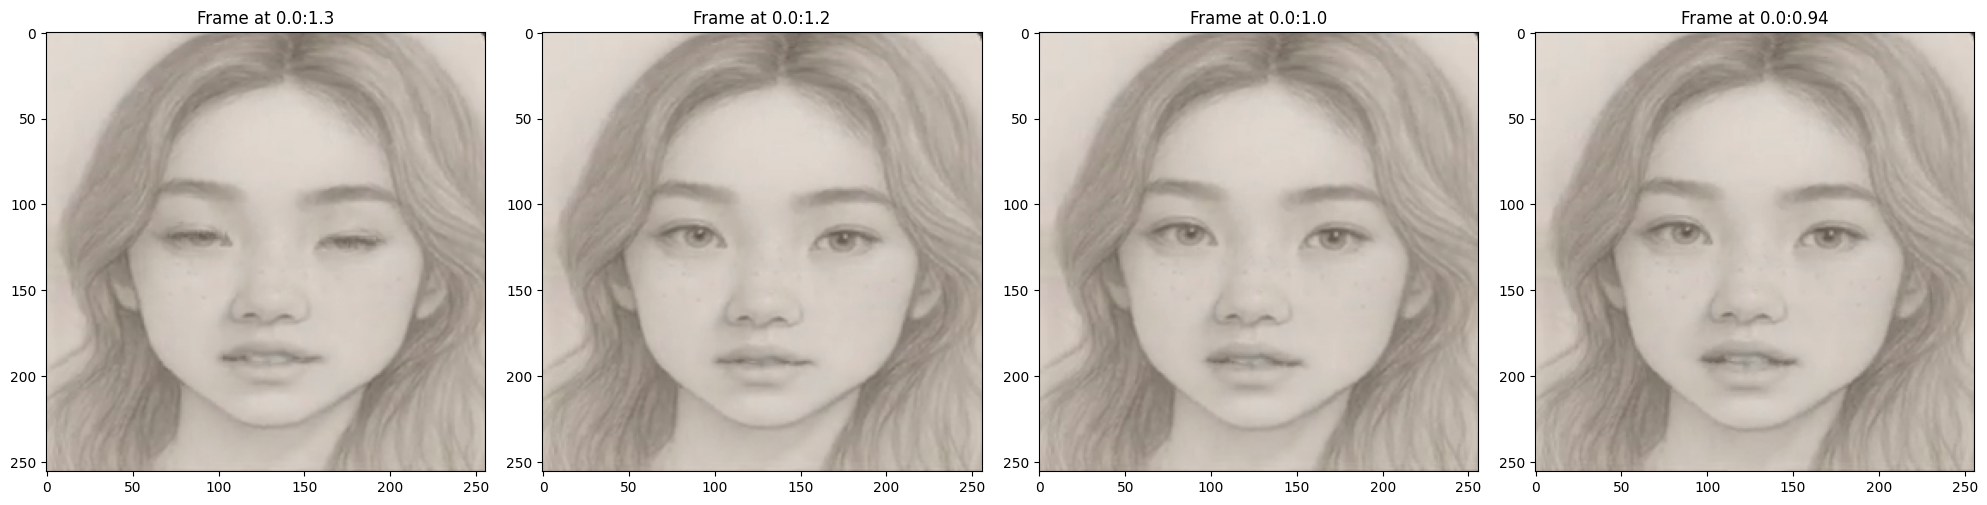

In [5]:
# Extract frames to be used to animate talking AI companion:
#    generated.mp4 created using https://github.com/yoyo-nb/Thin-Plate-Spline-Motion-Model

from moviepy.editor import VideoFileClip
from PIL import Image
import matplotlib.pyplot as plt

# Load the video
video_path = "generated_jenny.mp4"           # generated from ThinPlateSpline project
clip = VideoFileClip(video_path)

frame_times = [1.30, 1.20, 1.00, 0.94] # manually visual inspection of video frames
#frame_times = [3.00, 3.25, 3.37, 3.35] # alternative frames
frame_names = ["frame_blink.jpg","frame_rest.jpg","frame_soft.jpg","frame_loud.jpg"]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

# Time in seconds to extract the frame
for idx, frame_time in enumerate(frame_times):
    frame = clip.get_frame(frame_time)

    # Plot each frame in its respective subplot
    axes[idx].imshow(frame)
    axes[idx].set_title(f"Frame at {frame_time // 60:02}:{frame_time % 60:02}")
    
    image = Image.fromarray(frame)
    output_path = frame_names[ idx ]

    new_size = (200, 240)  # Width, Height
    resized_image = image.resize(new_size)
    resized_image.save(output_path)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()
